In [1]:
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # needed for heatmap
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import math
plt.rcParams['figure.figsize'] = [7, 5]

In [2]:
# define paths for data
FOLDER_PATH = 'data'
PREPROCESSED_PATH = 'preprocessed'
DATASET_NAME='df_ward_atlas.csv'
DATASET_PATH = join(FOLDER_PATH, PREPROCESSED_PATH, DATASET_NAME)

# load the data sets
df_ward_atlas=pd.read_csv(DATASET_PATH,index_col=0)
df_ward_atlas.head(1)

,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,Level 2 qualifications,Apprenticeship qualifications,Level 3 qualifications,Level >=4 qualifications,Other qualifications,% of 16+ who are schoolchildren and full-time students: Age 18 and over,Bad Health,Limited activities,Well-Being,IOD AVG
E05000026,449.535137,125.960833,9.488797,3.693721,0.58324,10.966213,4.97756,19.381951,1.564721,0.198172,...,0.115,0.011,0.085,0.345,0.167,14.3,4.3,5.1,7.897959,0.694138


# Dataset split

We use these features from the Atlas dataset to predict food consumption habits

In [3]:
age_cols = ['Aged 0-15', 'Aged 16-64', 'Aged 65+'] #sum to 1
ethnicities_cols = ['White', 'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'] #sum to 1
religion_cols = ['Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'No religion', 'Other religions', 'Religion not stated'] # sum to 1
born_cols = ['Born in UK', 'Not Born in UK'] # sum to 1
wealth_cols = ['Household Income Median', 'IOD AVG'] #'Well-Being'
qualilication_cols = ['No qualifications', 'Level 1 qualifications', 'Level 2 qualifications',
       'Apprenticeship qualifications', 'Level 3 qualifications',
       'Level >=4 qualifications', 'Other qualifications'] # sum to 1 
disability_cols = ['Bad Health', 'Limited activities']
all_features = age_cols + ethnicities_cols + religion_cols + born_cols + wealth_cols + qualilication_cols + disability_cols

These columns refer to absolute values of nutrients. We will use them as labels for some of the models

In [4]:
labels_abs = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']

One can also predict not absolute values, but fractions of nutrients to build a distribution of all the nutrients. While predicting the distribution model does not have to predict the total energy of the typical product. Therefore it has an opportunity to extract more properties of the nutrients. Even if we care about total values we can train the model to predict the distribution and total energy separately, so it won't need to apply normalization of distribution to the value of total energy.

In [7]:
labels_f=['f_energy_fat','f_energy_saturate','f_energy_sugar','f_energy_protein','f_energy_carb','f_energy_fibre','f_energy_alcohol']

In [8]:
all_labels=labels_abs+labels_f

# Searching for the most important features

If we want to extract the interesting food habits of different demographic groups we need to look for those features that make the highest impact and analyze relations between them. One of the common ways to do so is to train linear regression to predict a given nutrient based on demographic features. Consideration of linear regression coefficients will give us insights on what features make the highest impact in consumption rates of the nutrient predicted, along with knowledge of whether this feature increases the nutrient use or decreases it. However, to obtain credible results we need to massage the data in the first place.  

## Massaging the data

In [9]:
from sklearn.metrics import r2_score

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression

def Train_model(Model,x_data,y_data):
    X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size = 0.2)
    Model.fit(X_train,y_train)
    y_pred=Model.predict(X_test)
    return Model,r2_score(y_test,y_pred)

### Unreliable results?

In [10]:
print('Number of input features ',len(all_features))

Number of input features  30


In [11]:
print('Number of notes in the dataset ',len(df_ward_atlas))

Number of notes in the dataset  483


So with our linear regression, we have 30 coefficients for demographic features plus 1 bias to predict. And we have only 483 notes, which, moreover, have to be split into train and test datasets.

We want our linear regressions to extract general dependencies between features and labels, however, given such a small relative number of notes in the dataset, there can be troubles solving this problem. We can end up with cases when general dependence is not explicit in a given train dataset, so the model extracts relations that are of a high value for this specific train dataset. It is needless to say that an overfitted model that is highly dependent on a random splitting dataset is not the thing we are eager to obtain.

In order to consider only reliable results for each nutrient, we made 1000 pairs of randomly split train/test datasets. We trained, respectively, 1000 models and evaluated confidence intervals of R^2 score on the corresponding test datasets. Finally, we use quite a 
heuristic approach to evaluating reliability. We treat the model as reliable if its 95% confidence intervals cover a range of R^2 values less than 1/4. So the random dataset split governs no more than a fourth of the variance explained by the model.

#### Nutrien absolute values

In [25]:
from tqdm import tqdm

x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[labels_abs]

#Train thousand models for predicting each nutrient to estimate R^2 confidence intervals 
Linear_models_scores=np.zeros((1000,len(y_data.columns.values)))
for i in tqdm(range(1000)):
    Linear_scores=[]

    for column in y_data.columns.values:
        Model,R_2=Train_model(LinearRegression(),x_data,y_data[column])
        Linear_scores.append(R_2)
    Linear_models_scores[i]=Linear_scores

100%|██████████| 1000/1000 [01:05<00:00, 15.98it/s]


#### R^2 scores histograms for target labels

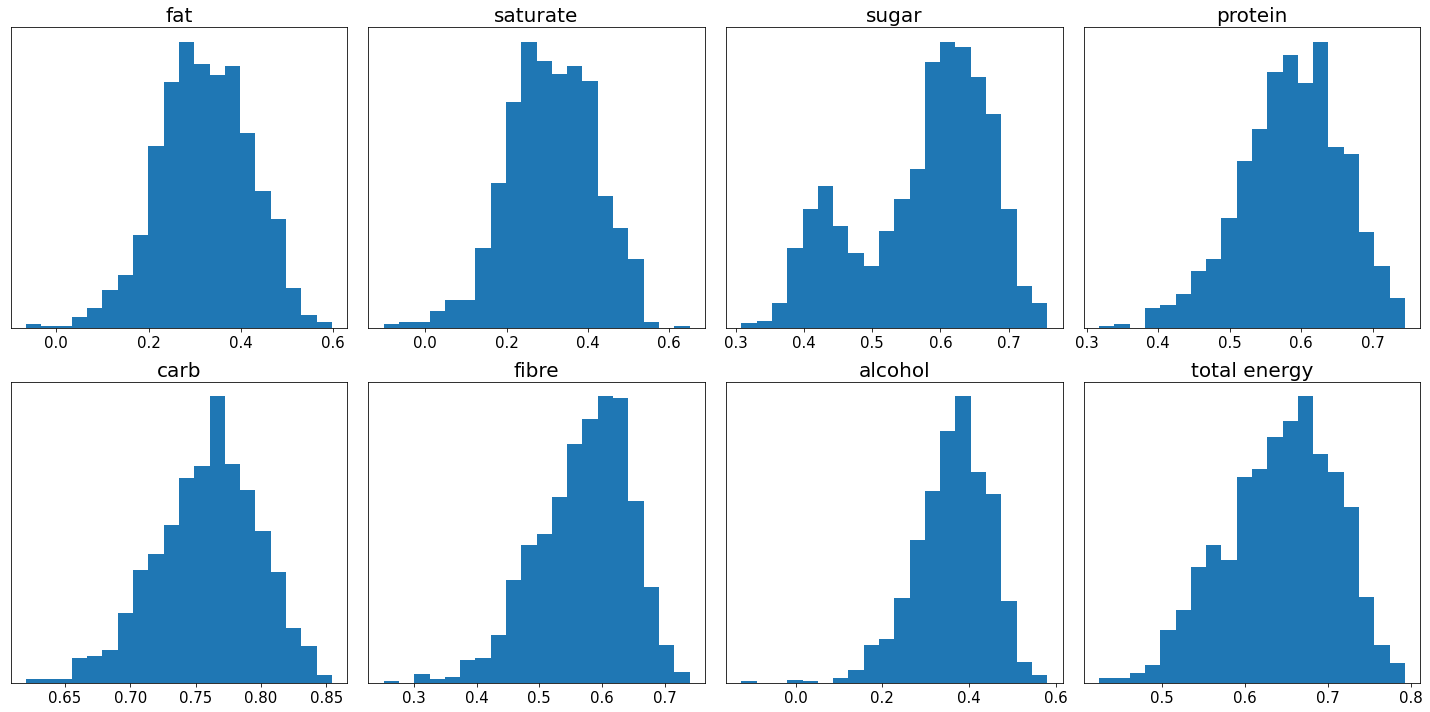

In [27]:
# plotting histograms for every feature
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axs_flat = axs.flatten()
Nutrient_names=[ x[7:] for x in y_data.columns.values]
Nutrient_names[-1]='total energy'

# plot from [2:] since first two columns are not numerical values
for idx in range(Linear_models_scores.shape[1]):
    axs_flat[idx].hist(Linear_models_scores[:,idx], bins=20)
    axs_flat[idx].set_title(Nutrient_names[idx],{'fontsize': 20})
    axs_flat[idx].set_yticks([])
    axs_flat[idx].tick_params(axis='x', which='major', labelsize=15)
fig.tight_layout()

#plt.savefig('Linear_reg_absolute_scores_distr')
plt.show()

#### Confidence intervals of R^2 scores

In [28]:
import statsmodels.stats.api as sms

df_R2_scores=pd.DataFrame(columns=['R^2','[0.025','0.975]','CI_high-CI_low','std'])

#Get all the R^2 properties: median, 5% confidence intervals
#95% variance of R^2 and its standard deviation
for i,label in enumerate(labels_abs):
    R2_scores=np.sort(Linear_models_scores[:,i])
    i_low=int(np.round(len(R2_scores)*0.025))
    i_high=int(np.round(len(R2_scores)*0.975))
    df_R2_scores.loc[label]=[np.median(R2_scores),R2_scores[i_low],R2_scores[i_high],R2_scores[i_high]-R2_scores[i_low],R2_scores.std()]

df_R2_scores

,R^2,[0.025,0.975],CI_high-CI_low,std
energy_fat,0.315888,0.122844,0.499312,0.376468,0.099669
energy_saturate,0.310172,0.080184,0.506659,0.426474,0.109262
energy_sugar,0.597647,0.385188,0.714264,0.329076,0.095110
energy_protein,0.591099,0.427146,0.708846,0.281700,0.071367
energy_carb,0.762022,0.671028,0.830479,0.159452,0.039097
energy_fibre,0.580041,0.411083,0.690345,0.279262,0.073832
energy_alcohol,0.370294,0.175698,0.501518,0.325819,0.085605
energy_tot,0.650278,0.507820,0.755314,0.247494,0.066405


#### Fractures of nutrient values

Let us inspect the performance of fractures prediction using the same procedure

In [29]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[labels_f]

from tqdm import tqdm
Linear_models_scores=np.zeros((1000,len(y_data.columns.values)))
for i in tqdm(range(1000)):
    Linear_scores=[]

    for column in y_data.columns.values:
        Model,R_2=Train_model(LinearRegression(),x_data,y_data[column])
        Linear_scores.append(R_2)
    Linear_models_scores[i]=Linear_scores

100%|██████████| 1000/1000 [01:02<00:00, 13.24it/s]


In [30]:
import statsmodels.stats.api as sms

df_R2_scores_f=pd.DataFrame(columns=['R^2','[0.025','0.975]','CI_high-CI_low','std'])

for i,label in enumerate(labels_f):
    R2_scores=np.sort(Linear_models_scores[:,i])
    i_low=int(np.round(len(R2_scores)*0.025))
    i_high=int(np.round(len(R2_scores)*0.975))
    df_R2_scores_f.loc[label]=[np.median(R2_scores),R2_scores[i_low],R2_scores[i_high],R2_scores[i_high]-R2_scores[i_low],R2_scores.std()]

df_R2_scores_f

,R^2,[0.025,0.975],CI_high-CI_low,std
f_energy_fat,0.420794,0.231422,0.594680,0.363258,0.090194
f_energy_saturate,0.422660,0.240721,0.557807,0.317086,0.082881
f_energy_sugar,0.399851,0.233098,0.541822,0.308723,0.075838
f_energy_protein,0.687151,0.563066,0.777783,0.214717,0.055061
f_energy_carb,0.713047,0.603863,0.786853,0.182989,0.047044
f_energy_fibre,0.760597,0.668537,0.835393,0.166856,0.045519
f_energy_alcohol,0.427914,0.226263,0.557229,0.330966,0.084442


#### Selecting reliable models
Reliable models are those that have CI_high-CI_low<0.25

In [31]:
df_Reliable_scores=df_R2_scores.append(df_R2_scores_f)
df_Reliable_scores=df_Reliable_scores[df_Reliable_scores['CI_high-CI_low']<0.25]
df_Reliable_scores

,R^2,[0.025,0.975],CI_high-CI_low,std
energy_carb,0.762022,0.671028,0.830479,0.159452,0.039097
energy_tot,0.650278,0.507820,0.755314,0.247494,0.066405
f_energy_protein,0.687151,0.563066,0.777783,0.214717,0.055061
f_energy_carb,0.713047,0.603863,0.786853,0.182989,0.047044
f_energy_fibre,0.760597,0.668537,0.835393,0.166856,0.045519


Using such confidence intervals filtering we are left with only those models that with the confidence of 97.5% explain at least half of the variance for a given nutrient, which is for sure refer to general dependence between demographic features and nutrient consumption rate. Moreover, random that refers to dataset split may only add an explanation to half of the remaining variance.  

#### supplementing the dataset

Luckily, we have all the fractions of nutrients and the total energy. Given the fact that fractions of carbs, protein, and fiber supplemented by fats make up 1 by the definition of a fraction, we can obtain a reliable model for fats as a residual from all the other fraction related reliable models. Moreover, we can get absolute values of nutrients, since we also have a reliable model for the total energy.

## Your food is who you are

If we are to compare linear regression coefficients for different features we have to be sure that these features initially have the same properties. For example, let us consider two features with the same standard deviations, and the same absolute value of the mean, but opposite sign. If their corresponding linear regression coefficients happen to be the same, we would have to account for initial signs to be opposite in order to understand that actual impacts of the features are also opposite. So why don't we just normalize all the features to have a mean value of 0 and a standard deviation of 1? Such a transformation excludes confusion with signs and makes it clear that the larger the coefficient, the larger the contribution. And considering only those coefficients, that have p_value<0.05 we can be sure of the significance of our results.

In [32]:
df_norm_features=df_ward_atlas[all_features].copy()

#normalizing to mean=0, std=1
df_norm_features=df_norm_features.apply(lambda x: (x.values-x.values.mean())/x.values.std(), axis=0)
df_norm_features[all_labels]=df_ward_atlas[all_labels]

In [34]:
norm_features=df_norm_features[all_features]
print('Characteristics of all normalized demographic features \n')
print('{:.2f} < mean < {:.2f} \n'.format(norm_features.mean(axis=0).min(),norm_features.mean(axis=0).max()))
print('{:.2f} < standard deviation < {:.2f}'.format(norm_features.std(axis=0).min(),norm_features.std(axis=0).max()))

Characteristics of all normalized demographic features 

-0.00 < mean < 0.00 

1.00 < standard deviation < 1.00


In [35]:
def to_formula(cols):
    cols = list(map(lambda s: 'Q("{}")'.format(s), cols))
    return ' + '.join(cols)
all_features_formula = to_formula(all_features)

def get_label_summary(label):
    #envoke a model that predicts label by all the demographic features
    model = smf.ols(formula='{} ~ {}'.format(label, all_features_formula),
              data=df_norm_features)
    res = model.fit()
    
    #Transform results with LR coefficients to DataFrame
    results_as_html = res.summary().tables[1].as_html()
    df_summary=pd.read_html(results_as_html, header=0, index_col=0)[0]
    
    #Consider only significant coefficients
    return df_summary[df_summary['P>|t|']<0.05],res

def cut_strings_borders(labels,start,finish):
    f=np.vectorize(lambda x: x[start:finish])
    return f(labels)

def Show_coefs(df,title):
    df=df.drop('Intercept')
    g=sns.barplot(x=df.index,y=df.coef,color='royalblue')
    g.set_xticklabels(labels=cut_strings_borders(df.index.values,3,-2),rotation=90)
    h = plt.ylabel('Impact')
    h.set_rotation(0)
    plt.title(title)
    plt.show()

In [36]:
reliable_linear_models=df_Reliable_scores.index.get_values()
print('Reliable linear models: {}'.format(reliable_linear_models))

LR_models=[]
LR_coef_dfs=[]
LR_coef_labels=[]

Reliable linear models: ['energy_carb' 'energy_tot' 'f_energy_protein' 'f_energy_carb'
 'f_energy_fibre']


### carb

In [37]:
target=reliable_linear_models[0]
df_coefs,model=get_label_summary(target)
LR_models.append(model)
LR_coef_dfs.append(df_coefs)
LR_coef_labels.append(target)
df_coefs

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,72.9516,0.119,614.634,0.000,72.718,73.185
"Q(""White"")",-1.5777,0.443,-3.561,0.000,-2.448,-0.707
"Q(""Mixed"")",-1.3063,0.277,-4.716,0.000,-1.851,-0.762
"Q(""Asian or Asian British"")",1.7263,0.583,2.959,0.003,0.580,2.873
"Q(""Jewish"")",-0.7872,0.170,-4.617,0.000,-1.122,-0.452
"Q(""Sikh"")",-0.4636,0.193,-2.400,0.017,-0.843,-0.084
"Q(""No religion"")",1.3227,0.375,3.525,0.000,0.585,2.060
"Q(""IOD AVG"")",-1.1860,0.428,-2.768,0.006,-2.028,-0.344


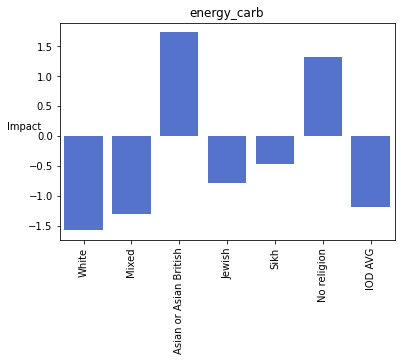

In [38]:
Show_coefs(df_coefs,target)

### fracture of carb

In [39]:
target=reliable_linear_models[3]
df_coefs,model=get_label_summary(target)
LR_models.append(model)
LR_coef_dfs.append(df_coefs)
LR_coef_labels.append(target)
df_coefs

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4046,0.000,1038.309,0.000,0.404,0.405
"Q(""White"")",-0.0063,0.001,-4.314,0.000,-0.009,-0.003
"Q(""Mixed"")",-0.0041,0.001,-4.516,0.000,-0.006,-0.002
"Q(""Asian or Asian British"")",0.0051,0.002,2.661,0.008,0.001,0.009
"Q(""Black or Black British"")",0.0048,0.001,4.377,0.000,0.003,0.007
"Q(""Sikh"")",-0.0020,0.001,-3.232,0.001,-0.003,-0.001
"Q(""IOD AVG"")",-0.0033,0.001,-2.370,0.018,-0.006,-0.001


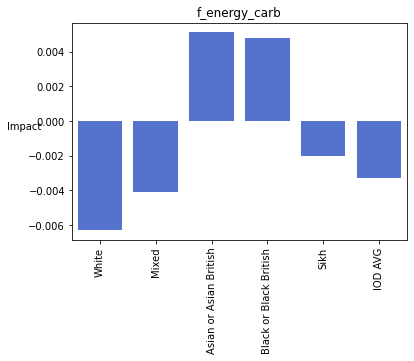

In [40]:
Show_coefs(df_coefs,target)

### fracture of protein

In [41]:
target=reliable_linear_models[2]
df_coefs,model=get_label_summary(target)
LR_models.append(model)
LR_coef_dfs.append(df_coefs)
LR_coef_labels.append(target)
df_coefs

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1173,0.000,666.594,0.000,0.117,0.118
"Q(""White"")",0.0040,0.001,6.077,0.000,0.003,0.005
"Q(""Mixed"")",0.0015,0.000,3.636,0.000,0.001,0.002
"Q(""Asian or Asian British"")",-0.0059,0.001,-6.864,0.000,-0.008,-0.004
"Q(""Black or Black British"")",0.0013,0.000,2.590,0.010,0.000,0.002
"Q(""Buddhist"")",0.0010,0.000,3.953,0.000,0.001,0.002
"Q(""Hindu"")",0.0018,0.001,3.387,0.001,0.001,0.003
"Q(""Muslim"")",0.0013,0.001,2.444,0.015,0.000,0.002
"Q(""Sikh"")",0.0018,0.000,6.359,0.000,0.001,0.002
"Q(""No religion"")",-0.0035,0.001,-6.238,0.000,-0.005,-0.002


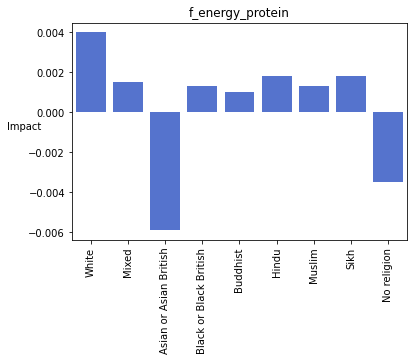

In [42]:
Show_coefs(df_coefs,target)

### fracture of fibre

In [43]:
target=reliable_linear_models[4]
df_coefs,model=get_label_summary(target)
LR_models.append(model)
LR_coef_dfs.append(df_coefs)
LR_coef_labels.append(target)
df_coefs

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.017000,0.000023,749.082,0.000,0.017000,0.017000
"Q(""Aged 0-15"")",-0.000900,0.000000,-2.427,0.016,-0.002000,-0.000000
"Q(""Aged 16-64"")",-0.001300,0.001000,-2.460,0.014,-0.002000,-0.000000
"Q(""Aged 65+"")",-0.001100,0.000000,-2.526,0.012,-0.002000,-0.000000
"Q(""White"")",0.000400,0.000085,4.571,0.000,0.000000,0.001000
"Q(""Asian or Asian British"")",-0.000500,0.000000,-4.847,0.000,-0.001000,-0.000000
"Q(""Christian"")",-0.000100,0.000066,-2.158,0.031,-0.000000,-0.000013
"Q(""Buddhist"")",0.000095,0.000034,2.808,0.005,0.000029,0.000000
"Q(""Hindu"")",0.000200,0.000067,2.476,0.014,0.000034,0.000000
"Q(""Jewish"")",0.000200,0.000033,4.677,0.000,0.000088,0.000000


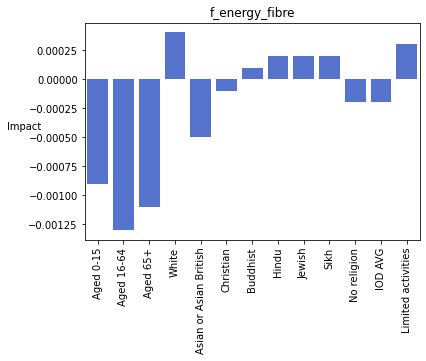

In [44]:
Show_coefs(df_coefs,target)

### energy tot

In [45]:
target=reliable_linear_models[1]
df_coefs,model=get_label_summary(target)
LR_models.append(model)
LR_coef_dfs.append(df_coefs)
LR_coef_labels.append(target)
df_coefs

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,180.1001,0.199,904.752,0.000,179.709,180.491
"Q(""Mixed"")",-1.2793,0.465,-2.754,0.006,-2.192,-0.366
"Q(""Hindu"")",-1.2215,0.589,-2.072,0.039,-2.380,-0.063
"Q(""Jewish"")",-2.3268,0.286,-8.138,0.000,-2.889,-1.765
"Q(""No religion"")",2.0922,0.629,3.324,0.001,0.855,3.329
"Q(""IOD AVG"")",-1.5521,0.719,-2.160,0.031,-2.964,-0.140


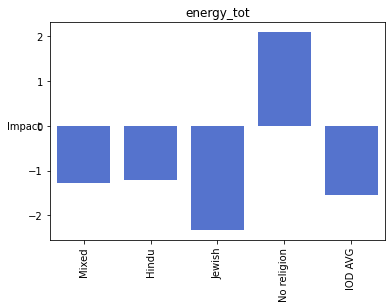

In [46]:
Show_coefs(df_coefs,target)

### residual fats

In [47]:
LR_coef_labels

['energy_carb',
 'f_energy_carb',
 'f_energy_protein',
 'f_energy_fibre',
 'energy_tot']

In [48]:
df_norm_features[labels_f].head(1)

,f_energy_fat,f_energy_saturate,f_energy_sugar,f_energy_protein,f_energy_carb,f_energy_fibre,f_energy_alcohol
E05000026,0.4564,0.177664,0.234428,0.106407,0.414333,0.015447,0.007414


We want to consider coefficients of linear regression predicting fracture of fats, however, the model predicting fracture of fats from the Tesco grocery dataset is not reliable. Since f_fats=1-f_protein-f_carbs-f_fibre, we can try to extract information of fats using reliable prediction models. However, we can not obtain coefficients for each feature of the fat model just using coefficients of the other models for this feature since the space of demographic features is not orthogonal. Nevertheless, we can treat the fracture of fat as residual from all the predictions of other nutrients fractions, train a model to predict this residual fraction, and consider the coefficients of this model.

In [50]:
#predicting fractions of protein, carbs, fibers, subtract them from 1 to obtain "predicted f_fat"
df_norm_features['predicted_f_fats']=1-np.sum([LR_models[i].predict(
    df_norm_features[all_features]).values for i in range(1,4)],axis=0)

### Predicted f_fat

In [51]:
target='predicted_f_fats'
df_coefs,model=get_label_summary(target)
LR_models.append(model)
LR_coef_dfs.append(df_coefs)
LR_coef_labels.append(target)
df_coefs

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.46110,1.630000e-17,2.830000e+16,0.0,0.461000,0.461000
"Q(""Aged 0-15"")",0.00770,2.710000e-16,2.840000e+13,0.0,0.008000,0.008000
"Q(""Aged 16-64"")",0.00800,3.720000e-16,2.140000e+13,0.0,0.008000,0.008000
"Q(""Aged 65+"")",0.00840,3.070000e-16,2.730000e+13,0.0,0.008000,0.008000
"Q(""White"")",0.00190,6.070000e-17,3.120000e+13,0.0,0.002000,0.002000
"Q(""Mixed"")",0.00260,3.800000e-17,6.840000e+13,0.0,0.003000,0.003000
"Q(""Asian or Asian British"")",0.00140,8.000000e-17,1.730000e+13,0.0,0.001000,0.001000
"Q(""Black or Black British"")",-0.00620,4.600000e-17,-1.350000e+14,0.0,-0.006000,-0.006000
"Q(""Other"")",-0.00140,3.850000e-17,-3.680000e+13,0.0,-0.001000,-0.001000
"Q(""Christian"")",0.00130,4.770000e-17,2.800000e+13,0.0,0.001000,0.001000


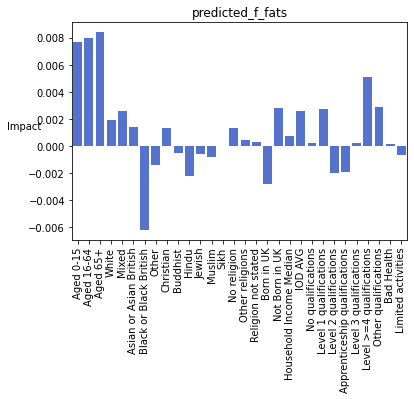

In [52]:
Show_coefs(df_coefs,target)

## Figure for all the features at once

Let's make a figure that would show linear regression coefficients for all the nutrients. Since I have already looked it up in the future, I know that we have either 6,5 or 2 and fewer plots for each nutrient. It makes no sense to show less than two because we want to make comparisons between different nutrients

In [53]:
def DS_features_to_LR_features(features):
    return ['Q("'+x+'")' for x in features]

def number_of_plots_for_feature_group(features):
    #select features that are significant for LR and are present in features to show
    LR_features=DS_features_to_LR_features(features)
    
    #Create array with indices of figures to show. (It is sensless to show less then 2)
    Mask_for_figures=np.array([np.isin(LR_coef_dfs[i].index,LR_features).sum()>1 
                              for i in range(len(LR_coef_dfs))])
    Figures_to_show=np.arange(len(Mask_for_figures))[Mask_for_figures]
    
    if len(Figures_to_show)<2:
        return 0,[]
    
    return Mask_for_figures.sum(), Figures_to_show

In [57]:
#Lists of features that should be considered for a given demographical groups
Features_to_inspect=[all_features,age_cols,ethnicities_cols,religion_cols,
                   born_cols,wealth_cols,qualilication_cols,disability_cols]

#Numbers of nutrients that should be shown for a given demographic group
Plots_to_show=np.array([number_of_plots_for_feature_group(features) for features in Features_to_inspect])

In [59]:
def Show_coefs(df,title):
    df=df.drop('Intercept')
    g=sns.barplot(x=df.index,y=df.coef,color='royalblue')
    g.set_xticklabels(labels=cut_strings_borders(df.index.values,3,-2),rotation=90)
    h = plt.ylabel('Impact')
    h.set_rotation(0)
    plt.title(title)
    plt.show()
    
Nutrient_names=['Carb',
 'Fracture of carb',
 'Fracture of protein',
 'Fracture of fibre',
 'Total energy', 'Residual fracture of fats']
    
def Show_coefs_for_feature(features_group_number):
    
    #Get names of demographic features to be used for a given group
    features=Features_to_inspect[features_group_number]
    
    #select features that are significant for LR and are present in features to show
    LR_features=DS_features_to_LR_features(features)
    
    plots_number,Figures_to_show=Plots_to_show[features_group_number]
    
    #Manage the displacement of the figures
    if plots_number==0:
        print('Nothing to compare')
        return
    elif plots_number==6:
        fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
        axs_flat = axs.flatten()
    elif plots_number==5:
        fig=plt.figure(figsize=(20,15))
        axs_flat=[]
        axs_flat.append(plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2))
        axs_flat.append(plt.subplot2grid((2,6), (0,2), colspan=2))
        axs_flat.append(plt.subplot2grid((2,6), (0,4), colspan=2))
        axs_flat.append(plt.subplot2grid((2,6), (1,1), colspan=2))
        axs_flat.append(plt.subplot2grid((2,6), (1,3), colspan=2))
    elif plots_number==2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        axs_flat = axs.flatten()
    else:
        print('Wrong plot_number')
        return
    
    #Plot everything
    for figure_index,label_index in enumerate(Figures_to_show):
        
        #extract only needed labels and features
        df_label=LR_coef_dfs[label_index]
        df=df_label.loc[np.isin(df_label.index,LR_features)]
        
        g=sns.barplot(ax=axs_flat[figure_index],x=df.index,y=df.coef,color='royalblue')
    
        g.set_xticklabels(labels=cut_strings_borders(df.index.values,3,-2),
                      fontdict={'fontsize': 15},rotation=90)
        axs_flat[figure_index].set_ylabel('')
        axs_flat[figure_index].set_title(Nutrient_names[label_index],{'fontsize': 20})

    axs_flat[0].set_ylabel('Linear regression coeffitient',{'fontsize': 15})
    fig.tight_layout()

#### All features

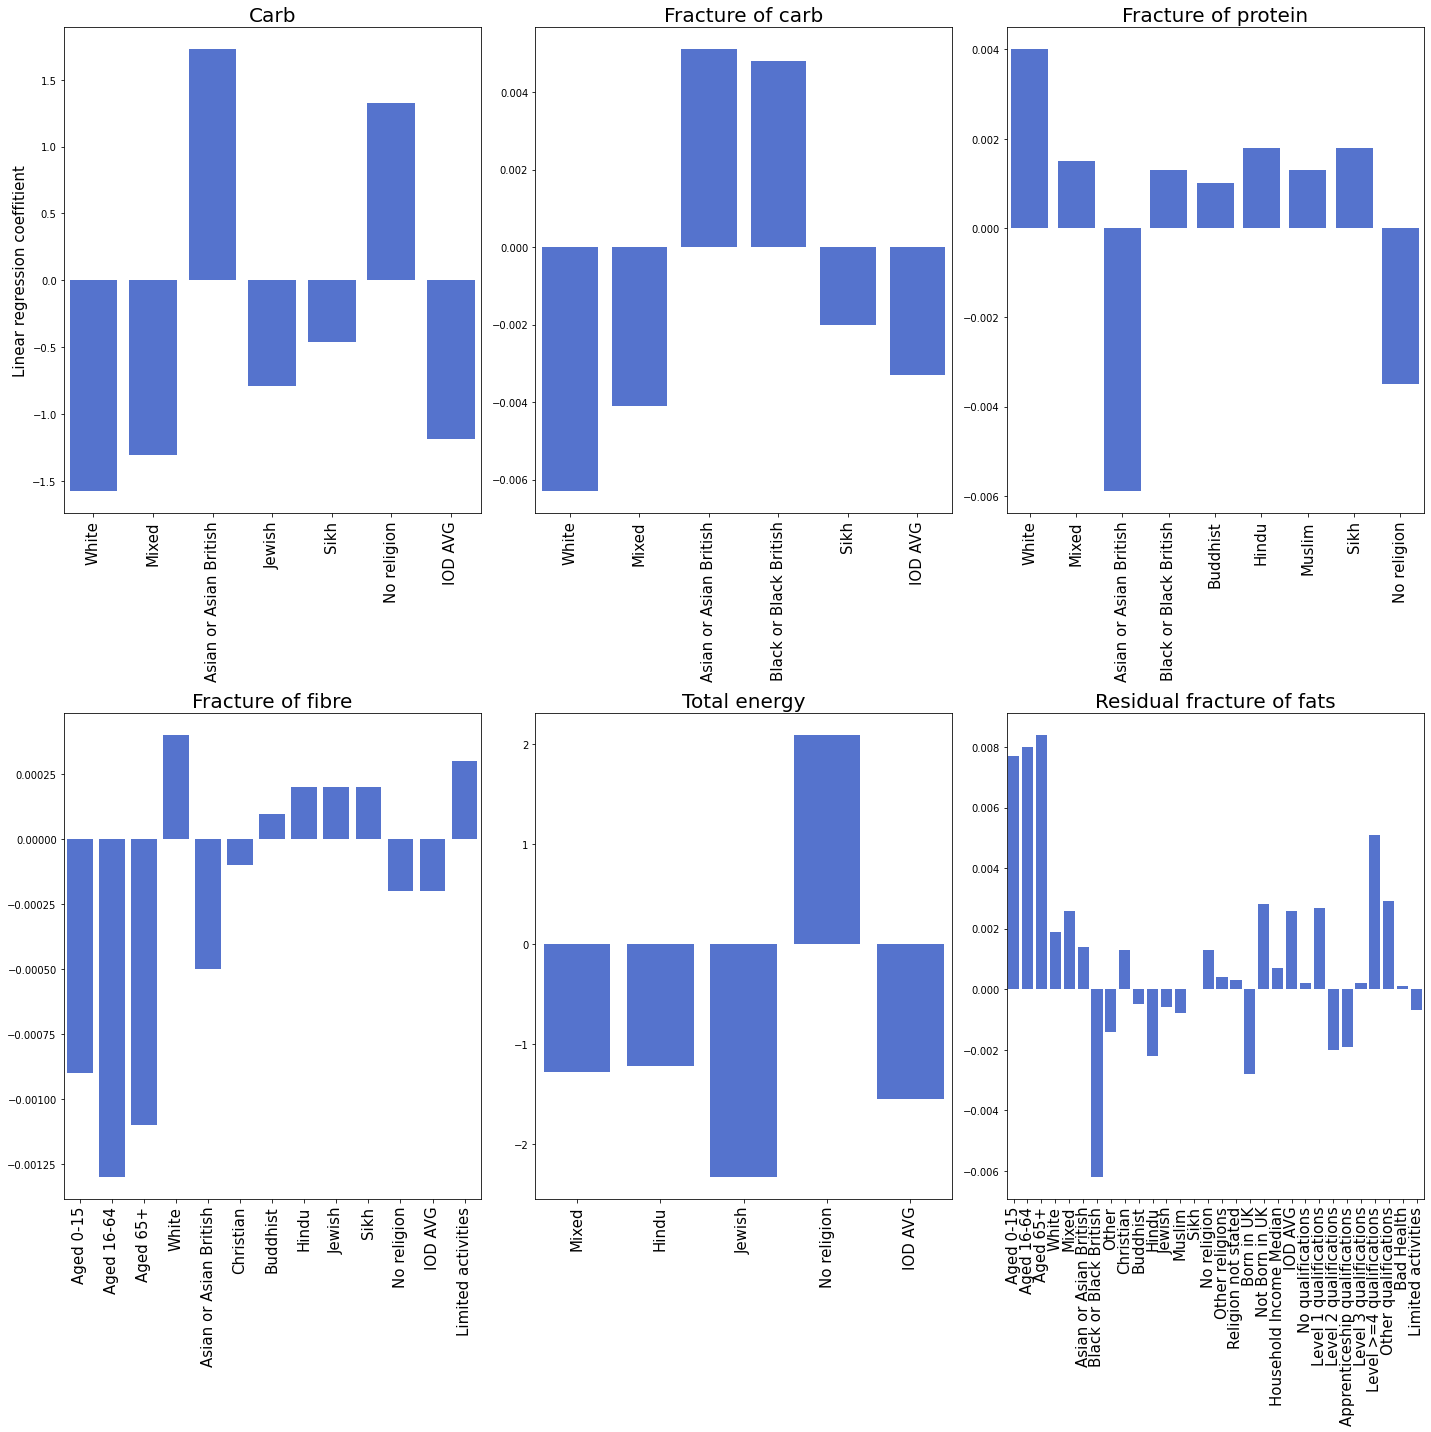

In [61]:
Show_coefs_for_feature(0)
#plt.savefig(join('Figures','All_features_coefs'))

In this figure coefficient of zero for a demographic group means that this group has a consumption rate of this nutrient equal to an average one. A positive coefficient means that the group consumes more than average food with this nutrient, whereas a negative coefficient means that the group consumes less

IOD AVG stands for the average index of deprivation. Based on the coefficients for it, we can state that deprived people are likely to consume more fats, but less other nutrients. Deprived people also consume less energy in total, it is
sensible since the group of deprived people includes poor ones
and poor people are unlikely to afford themselves eating a lot,
which decreases the total energy consumed. They are also likely to
eat cheap unhealthy food instead of high-quality meat, which
is shown by figures negative coefficients for proteins and fiber
along with a positive coefficient for fat.

Also one can see that consumption rates of fibers and fats are governed mostly by age.

### Analysis of demographic groups

### age

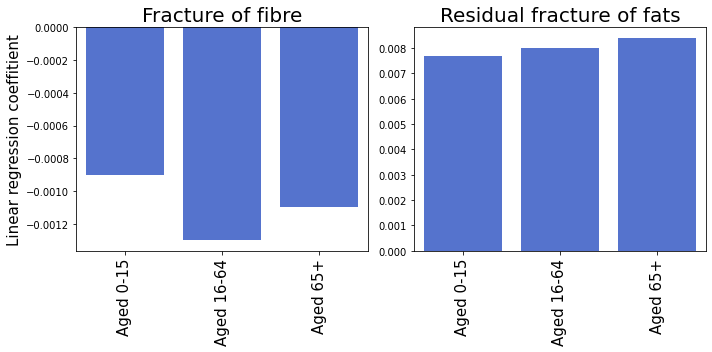

In [62]:
Show_coefs_for_feature(1)
#plt.savefig(join('Figures','Age_features_coefs'))

Adult people consume less fiber than others. With age fraction of consumed fats grows.

#### ethnicities

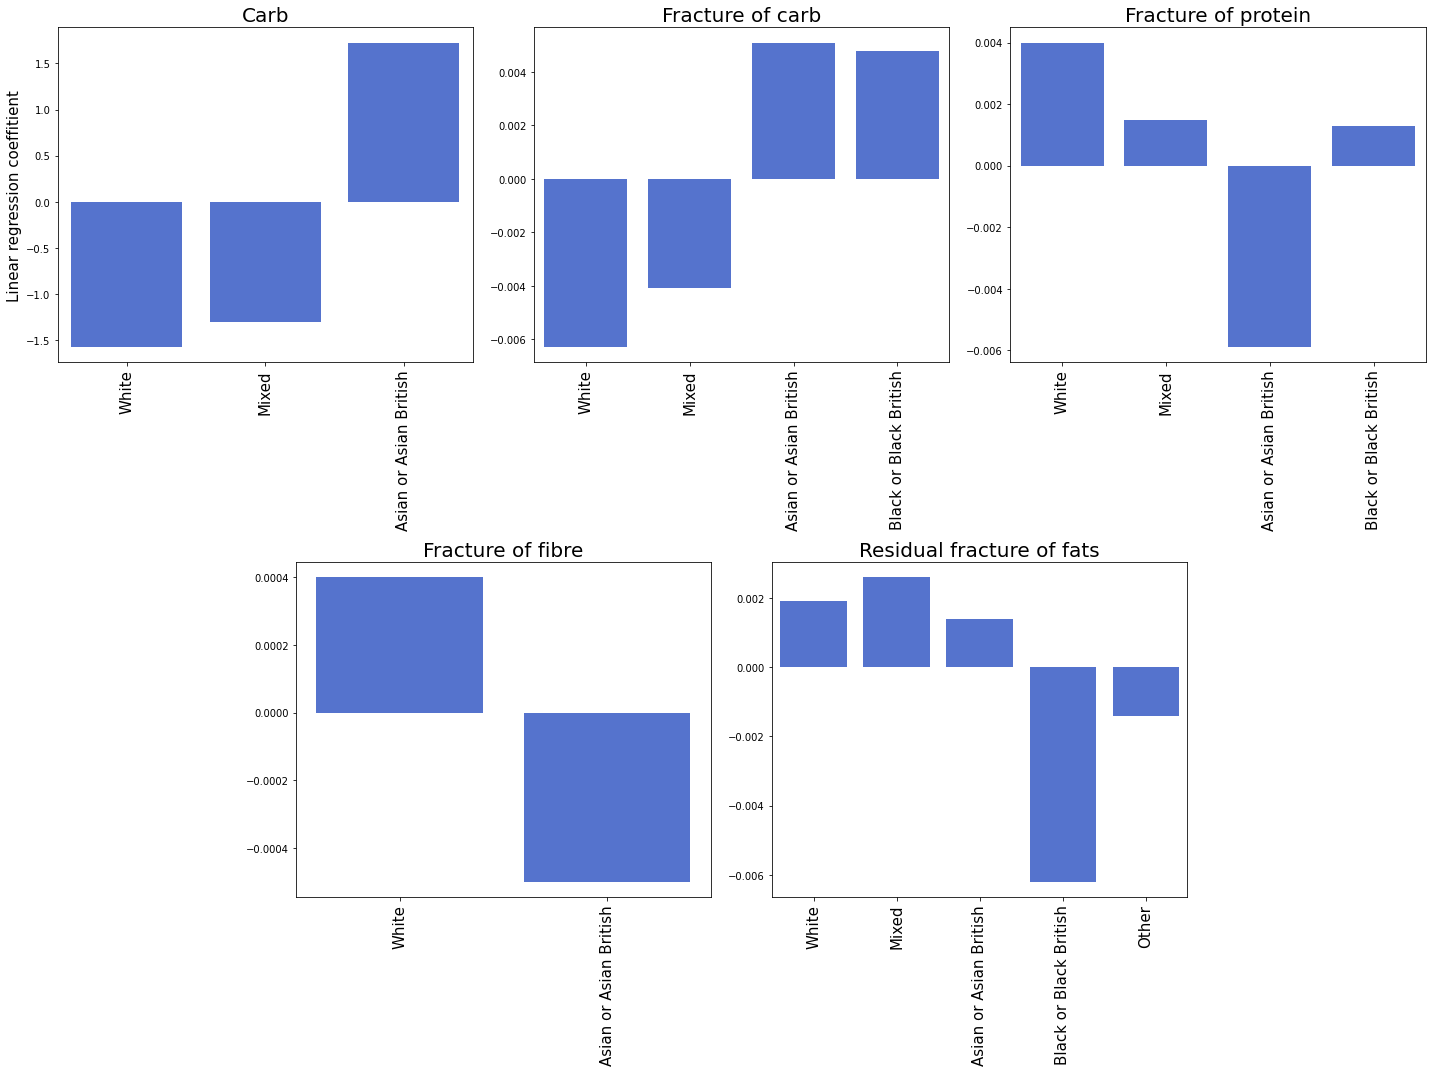

In [63]:
Show_coefs_for_feature(2)
#plt.savefig(join('Figures','Ethnicities_features_coefs'))

Asians:  
The presence of Asians drastically increases
the number of Carbohydrates, which can, probably, be explained
by a traditional preference for grains such as rice. Moreover, the negative coefficient for fiber enables us to conclude that they prefer white rice to brown. At the same
time, the negative coefficient for proteins and the positive one for fats tell us that Asians prefer fatty protein sources like fish, rather than dry ones like chicken. Or they can get fats, not animal-based products, which provide also protein, but Asians can consume growth products, that are rich in fats, like avocados.  

Blacks:  
In terms of meat, for Black people conclusions are the opposite. The presence of Black people drastically decreases the consumption of fats and increases protein. So we can say that Black people prefer very dry meat to the other meat types, probably, they prefer chicken.

Whites:  
The presence of White people, in a turn, is imbalanced in terms of low carbohydrate consumption in relation to an average person.

#### Religions

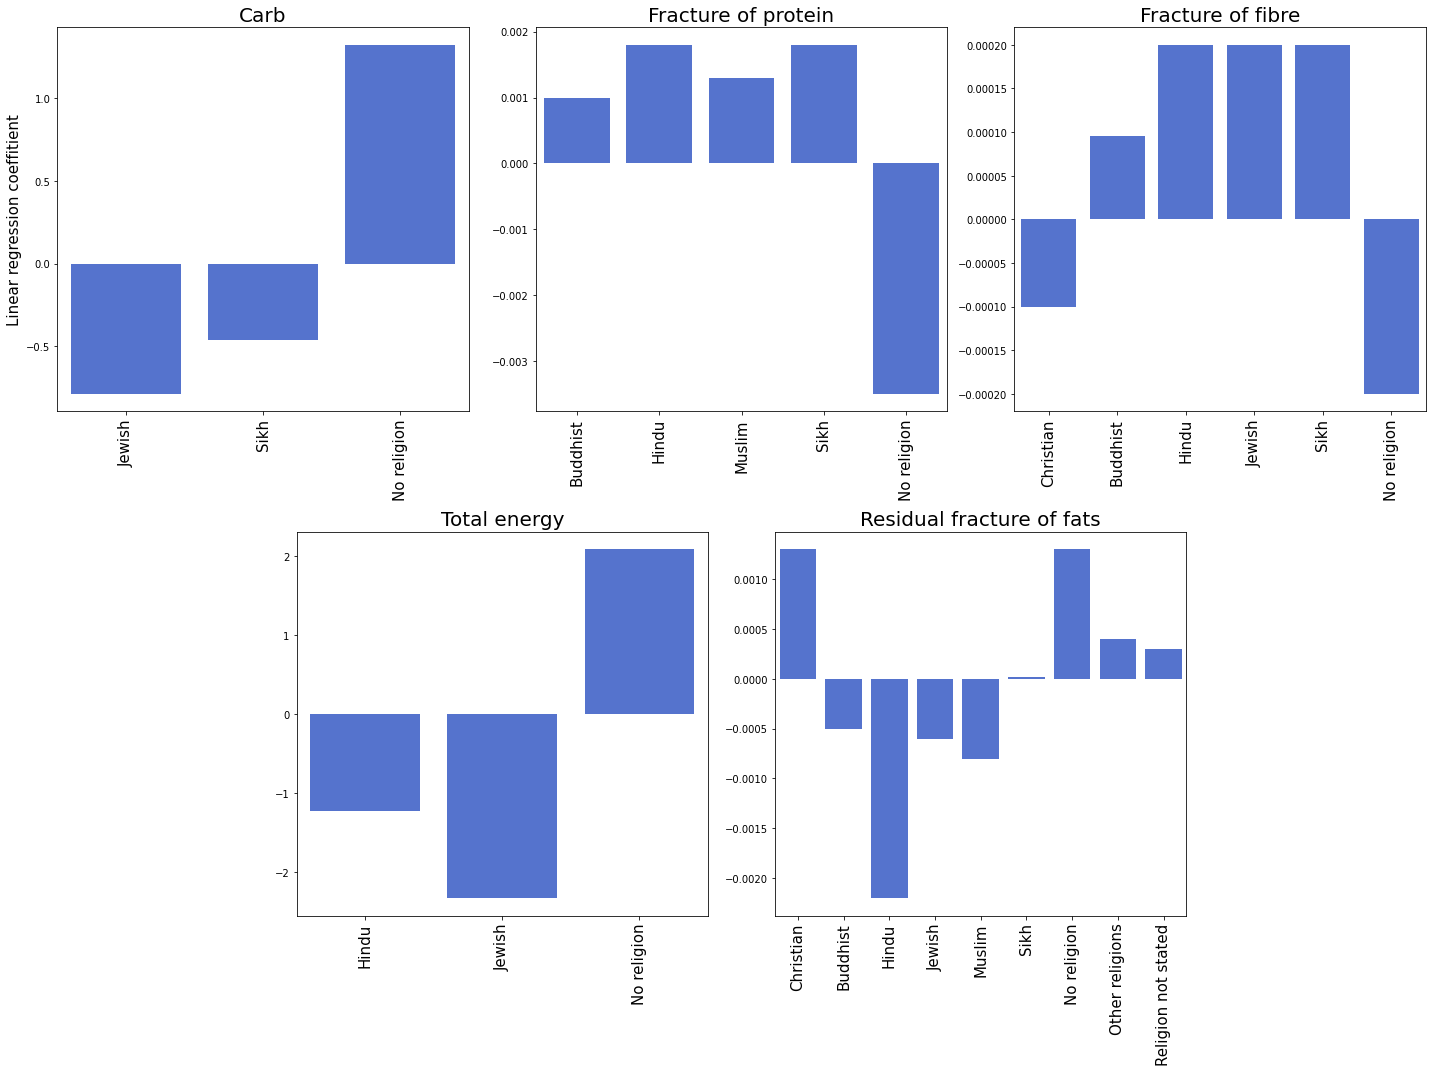

In [64]:
Show_coefs_for_feature(3)
#plt.savefig(join('Figures','Religions_features_coefs'))

Fibers:  
As we can see some religions strongly affect the diet. Some religions like Buddhist, Hindu, and Sikh have Vegetarianism, Jewish consider most of the plant-based food kosher. It all can be seen by the drastic increase in fiber consumption.

Fats:  
There was a research that claims Buddhist to have less body fat than an average person, Hindu and Sikh exclude fats from their diet, for Jewish food greased with animal-based fats considered to be not kosher. The presence of Muslims decreases fats consumption, probably because the fattiest meat, which is pork, appear to be prohibited in this religion

Proteins:  
However, some mentioned religions increase protein consumption rates. Probably, because for some religions dairy products, beans or soy are welcome. 

#### Born in UK

In [65]:
Show_coefs_for_feature(4)

Nothing to compare


#### wealth

In [66]:
Show_coefs_for_feature(5)

Nothing to compare


#### qualification

In [67]:
Show_coefs_for_feature(6)

Nothing to compare


#### disability

In [68]:
Show_coefs_for_feature(7)

Nothing to compare


### Alex's case study as an example?

# Nutrient distribution

Meet John, he is an entrepreneur who has just opened a new grocery store in one of London wards and now he has to fill it with products to sell. Since John still lives in a capitalist society he is eager to get the most revenue out of the shop. So he wants to buy exactly those types and amounts of products that would satisfy the ward's residents' appetite, though he doesn't want to buy any excess products that they have to be thrown away.  

John is not good with statistics, so he asks you to help him make money by answering two questions: what products should he buy, and moreover, how much?

In other words, he wants us to predict the distribution of nutrients and total energy of a typical product for his ward, given the demographical data of the ward's residents. Let's help him!

Most of the dependencies between nutrients and demographics are sensibly predicted to be linear, however, some relations appear to be better described by nonlinear models. For every nutrient, we trained linear regression and several gradients boosting regression with different hyperparameters. We used only reliable models, as in the analysis of the coefficients. Then we compared R^2 scores and test datasets to chose the best ones and unite them into one big model that predicts all the parameters of the typical product.

In [70]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

def Train_all_labels(Model_to_train,x_data,y_data):
    Models_for_labels={}
    Scores_for_labels={}
    df_Scores=pd.DataFrame(columns=y_data.columns.values)
    
    #Train one model for each nutrient considered 
    for column in y_data.columns.values:
        Trained_Model,R_2=Train_model(Model_to_train,x_data,y_data[column])
        Models_for_labels[column]=Trained_Model
        Scores_for_labels[column]=R_2

    return Models_for_labels,Scores_for_labels

def Train_Gradient_Boosting(x_data,y_data):
    
    #Parameters for GradBoost grid search
    parameters={'n_estimators':range(50,350,50),
           'learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]}

    GradientB_models={}
    GradientB_scores={}

    #Dataset split
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
    
    
    for i,column in tqdm(enumerate(y_data.columns.values)):
        #Envoke GridSearch,perform fitting, save the best model
        G_search=GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
                     param_grid=parameters, scoring='r2',iid=False,cv=5)
        G_search.fit(X_train,y_train[column])
        Model=G_search.best_estimator_
        R_2=r2_score(y_test[column],Model.predict(X_test))
        GradientB_models[column]=Model
        GradientB_scores[column]=R_2
    
    return GradientB_models,GradientB_scores

In [71]:
reliable_labels=['energy_tot','f_energy_protein','f_energy_carb','f_energy_fibre']

In [72]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[reliable_labels]

Linear_models,Linear_scores=Train_all_labels(
    LinearRegression(),x_data,y_data)

GradBoost_models,GradBoost_scores=Train_Gradient_Boosting(x_data,y_data)

4it [03:57, 58.06s/it]


In [73]:
df_Scores=pd.DataFrame(columns=Linear_scores.keys())
df_Scores.loc['Linear Regression R^2']=Linear_scores
df_Scores.loc['Gradient Boosting R^2']=GradBoost_scores
df_Scores

,energy_tot,f_energy_protein,f_energy_carb,f_energy_fibre
Linear Regression R^2,0.570166,0.712354,0.666144,0.766981
Gradient Boosting R^2,0.617975,0.692473,0.691884,0.700378


Let us unify the best models to predict residual fat

In [74]:
Architectures=[Linear_models,GradBoost_models]
Optimal_Models={}
Optimal_Scores={}

for i,column in tqdm(enumerate(y_data.columns.values)):
    #Choose architecture with the highest R^2 for a given label
    #[-1] means that if two models have the same score, we would chose adjusted one
    Number_of_optimal_architecture=np.where(
        df_Scores[column]==df_Scores[column].max())[0][-1]
    #Assign optimal model for given label with this model
    Optimal_Models[column]=Architectures[Number_of_optimal_architecture][column]
    Optimal_Scores[column]=df_Scores[column][Number_of_optimal_architecture]

df_Scores.loc['Optimal model R^2']=Optimal_Scores
df_Scores.loc['Optimal model R^2']

4it [00:00, 567.72it/s]


energy_tot          0.617975
f_energy_protein    0.712354
f_energy_carb       0.691884
f_energy_fibre      0.766981
Name: Optimal model R^2, dtype: float64

In [95]:
#reliable_labels[1:] are only fractions
Predicted_fats=pd.Series(data=1-np.sum([Optimal_Models[label].predict(x_data) 
                                   for label in reliable_labels[1:]],axis=0),
                         name='predicted_f_fats').to_frame()

In [96]:
Linear_fat_model,Linear_fat_score=Train_all_labels(
    LinearRegression(),x_data,Predicted_fats)

GradBoost_fat_model,GradBoost_fat_score=Train_Gradient_Boosting(x_data,Predicted_fats)

1it [01:07, 67.30s/it]


In [97]:
column='predicted_f_fats'

df_Scores[column]=[Linear_fat_score[column],GradBoost_fat_score[column],np.nan]

Architectures=[Linear_fat_model,GradBoost_fat_model]
Number_of_optimal_architecture=np.where(
        df_Scores[column]==df_Scores[column].max())[0][-1]
#Assign optimal model for given label with this model
Optimal_Models[column]=Architectures[Number_of_optimal_architecture][column]
Optimal_Scores[column]=df_Scores[column][Number_of_optimal_architecture]
df_Scores.loc['Optimal model R^2']=Optimal_Scores
df_Scores.loc['Optimal model R^2']

energy_tot          0.617975
f_energy_protein    0.712354
f_energy_carb       0.691884
f_energy_fibre      0.766981
predicted_f_fats    0.864792
Name: Optimal model R^2, dtype: float64

With this model we can predict all the main constituents of a typical product and its total energy, so we have found the answers to John's questions.